# Homework 4: Earthquakes and Plate Tectonics

### Import necessary libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.dates as mdates
from matplotlib import cm
import cartopy.crs as ccrs
from cartopy.io.shapereader import Reader
from geopy import distance
import datetime
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score

## 1. Plate Tectonics

### 1.1 Topography

Let us use the `Orthographic` projection (A GLOBE! in the XKCD map projection cartoon) to look at the large underwater mountain range of the Mid-Atlantic ridge.

The `plt.contourf` function is slow such that we will need to have some patience when running the plotting code.

In [2]:
## Load the topography data using np.loadtxt
lats = np.loadtxt('./data/etopo20lats.txt') 
lons = np.loadtxt('./data/etopo20lons.txt')
topo_grid = np.loadtxt('./data/etopo20data.txt')

## Create a meshgrid for latitude and longitude using np.meshgrid
lon_grid, lat_grid = np.meshgrid(lons, lats)

## Check the shape of lat_grid, lon_grid, and topo_grid are the same
print(f"Shape of lat_grid: {lat_grid.shape}, Shape of lon_grid: {lon_grid.shape}, Shape of topo_grid: {topo_grid.shape}")

## Downsample the data to make the plotting faster
lon_grid = lon_grid[::2, ::2]
lat_grid = lat_grid[::2, ::2]
topo_grid = topo_grid[::2, ::2]

Shape of lat_grid: (540, 1081), Shape of lon_grid: (540, 1081), Shape of topo_grid: (540, 1081)


- Plot the topography using the Orthographic projection

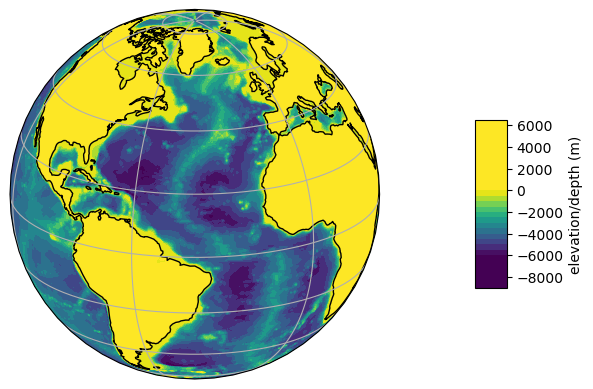

In [3]:
## Make a figure
plt.figure()

## Set the projection
ax = plt.axes(projection=ccrs.Orthographic(central_longitude=-40.0, central_latitude=20.0))
ax.set_global()

## Plot the topography using the Orthographic projection
plt.contourf(lon_grid, lat_grid, topo_grid,30,vmax=0,vmin=-6000,
             cmap=cm.viridis,transform=ccrs.PlateCarree())

## Add coastlines and gridlines
ax.coastlines()
ax.gridlines()

## Add colorbar
color_ax = plt.axes([0.95, 0.3, 0.05, 0.35])
plt.colorbar(cax=color_ax, label='elevation/depth (m)')

plt.show()

### 1.2 Seafloor age

Plot seafloor age looking at North Atlantic


In [4]:
## Load the seafloor age data
seafloor_age_data = pd.read_csv('data/age.csv')

## extract longitude, latitude, and age
age_longitude = seafloor_age_data['longitude'].values
age_latitude = seafloor_age_data['latitude'].values
age = seafloor_age_data['age_Ma'].values

## reshape the data to 2D arrays. Hint: the shape of the data is (901,1801)
age_grid = age.reshape((901,1801))
age_long_grid = age_longitude.reshape((901,1801))
age_lat_grid = age_latitude.reshape((901,1801))

## check the shape of the data
print(f"Shape of age_grid: {age_grid.shape}, Shape of age_long_grid: {age_long_grid.shape}, Shape of age_lat_grid: {age_lat_grid.shape}")

## Downsample the data to make the plotting faster
age_long_grid = age_long_grid[::4, ::4]
age_lat_grid = age_lat_grid[::4, ::4]
age_grid = age_grid[::4, ::4]


Shape of age_grid: (901, 1801), Shape of age_long_grid: (901, 1801), Shape of age_lat_grid: (901, 1801)


- Plot the seafloor age using the Orthographic projection

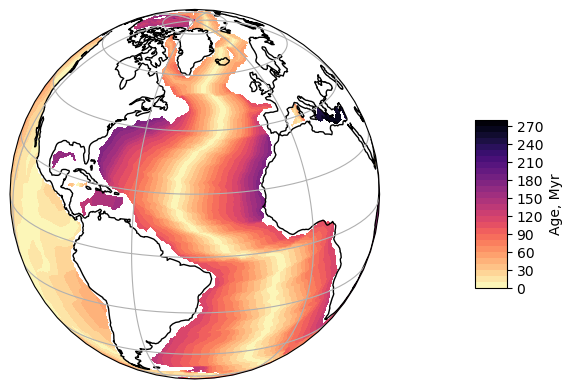

In [5]:
## Make a figure
plt.figure()

## Set the projection
ax = plt.axes(projection=ccrs.Orthographic(central_longitude=-40.0, central_latitude=20.0))
ax.set_global()

## Plot the seafloor age using the Orthographic projection
plt.contourf(age_long_grid, age_lat_grid, age_grid,30,
             cmap=cm.magma_r,transform=ccrs.PlateCarree())

## Add coastlines and gridlines
ax.coastlines()
ax.gridlines()

## Add colorbar
color_ax = plt.axes([0.95, 0.3, 0.05, 0.35])
plt.colorbar(cax=color_ax, label='Age, Myr') 

plt.show()

Question: What patterns do you observe? Where is the youngest seafloor in relation to the seafloor ridges we observed in our map of topography? Where is the oldest seafloor? 

What was the position of the continents like when the oldest seafloor formed?

## 2. Earthquake Catalog

Based on the seafloor age data, we know that the tectonic plates are moving away from the ridges and towards the trenches.

The movement of the plates will compress and stretch the plates. The accumulated stress will eventually be too much and the plates will break, causing an earthquake.

Large earthquakes are often associated with plate boundaries. Let's continue to explore the earthquake data to see if we can find any patterns.


- 2022's tragic earthquake in Turkey

https://earthquake.usgs.gov/earthquakes/eventpage/us6000jllz/executive

https://earthquake.usgs.gov/earthquakes/map/?currentFeatureId=us6000jllz&extent=-26.11599,-43.59375&extent=61.39672,100.89844&sort=largest&listOnlyShown=true

<img src="images/new-maps-of-global-geo.jpg" width=50%>
> Source: Hasterok et al., 2022


- Load the Earthquake Catalog

Load the .csv (comma separated values) data file of all the earthquakes of magnitude 4 and higher from 2000 - 2012 in the ANSS (Advanced National Seismic System) Comprehensive Catalog or "ComCat."

The ANSS Comprehensive Catalog (ComCat) http://www.quake.geo.berkeley.edu/anss/catalog-search.html

This data set has the following columns:

```DateTime, Latitude, Longitude, Depth, Magnitude, MagType, NbStations, Gap, Distance, RMS, Source, EventID```

Let's import it using the pandas `pd.read_csv()` function. We can see the first 5 rows of the dataframe using the `.head()` function.

In [6]:
## Load the earthquake data, skipping the first 7 rows using header=7
EQ_data = pd.read_csv('data/ANSS_2000_2012.csv', header=7)

## Check the first 5 rows of the dataframe
EQ_data.head()


,DateTime,Latitude,Longitude,Depth,Magnitude,MagType,NbStations,Gap,Distance,RMS,Source,EventID
0,2000/01/01 01:19:26.99,41.927,20.543,10.0,4.8,ML,187,NaN,NaN,1.14,NEI,2.000010e+11
1,2000/01/01 02:12:13.45,-11.348,164.568,33.0,4.3,Mb,9,NaN,NaN,1.16,NEI,2.000010e+11
2,2000/01/01 04:30:10.37,-26.012,-68.803,105.0,4.5,Mb,44,NaN,NaN,0.91,NEI,2.000010e+11
3,2000/01/01 05:24:35.29,36.874,69.947,54.3,5.1,Mw,181,NaN,NaN,0.83,NEI,2.000010e+11
4,2000/01/01 05:58:19.78,-60.722,153.670,10.0,6.0,Mw,87,NaN,NaN,1.05,NEI,2.000010e+11


Recall from the homework that Pandas dataframe columns can be accessed using bracket notation with the name of the column as a string:

In [7]:
## Access the Magnitude column
EQ_data['Magnitude']

0         4.8
1         4.3
2         4.5
3         5.1
4         6.0
         ... 
159016    4.0
159017    4.5
159018    4.4
159019    5.2
159020    4.6
Name: Magnitude, Length: 159021, dtype: float64

- What is the largest magnitude earthquake in our catalog?

In [8]:
## Find the largest magnitude earthquake in our catalog
largest_magnitude = EQ_data['Magnitude'].max()

print(f"The largest magnitude earthquake in our catalog is {largest_magnitude}")

The largest magnitude earthquake in our catalog is 9.1


- Determining when and where the largest Earthquake happened

In [9]:
## Find the date of the largest earthquake. Hint: using the `==` operator, e.g. EQ_data['DateTime'][EQ_data['Magnitude'] == largest_magnitude], to filter the dataframe, and `.values[0]` to get the first value of the filtered dataframe
largest_eq_date = EQ_data['DateTime'][EQ_data['Magnitude'] == largest_magnitude].values[0]

print(f"The largest earthquake in our catalog happened on {largest_eq_date}")

The largest earthquake in our catalog happened on 2011/03/11 05:46:24.12


- Determine where the earthquake happened

In [10]:
## Find the longitude and latitude of the largest earthquake
largest_eq_lon = EQ_data['Longitude'][EQ_data['Magnitude'] == largest_magnitude].values[0]
largest_eq_lat = EQ_data['Latitude'][EQ_data['Magnitude'] == largest_magnitude].values[0]

print(f"The largest earthquake in our catalog happened at {largest_eq_lon} longitude and {largest_eq_lat} latitude")

The largest earthquake in our catalog happened at 142.373 longitude and 38.297 latitude


There are many colormaps available in Matplotlib: https://matplotlib.org/stable/tutorials/colors/colormaps.html

<img src="https://matplotlib.org/stable/_images/sphx_glr_colormaps_007_2_00x.png" width=30%>

There are many different markers available in Matplotlib

<img src="https://matplotlib.org/stable/_images/sphx_glr_marker_reference_002_2_00x.png" width=30%>

Let's plot a red square at the location of the largest earthquake in our catalog. 

To the `plt.scatter` function, add `s=100` to adjust the size of the marker, add `color='red'` to change the color, add `marker=s` to make it a square. 




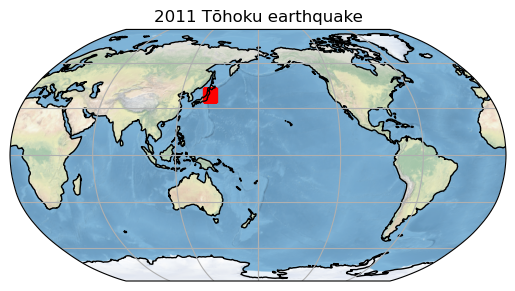

In [11]:
## Make a figure
plt.figure()

## Set the projection using ccrs.Robinson(central_longitude=180)
ax = plt.axes(projection=ccrs.Robinson(central_longitude=180))
ax.set_global()

## Plot the largest earthquake, using s=100, marker='s', color='red'
plt.scatter(largest_eq_lon,largest_eq_lat,s=100, marker='s',color='red',transform=ccrs.PlateCarree())

## Add coastlines, stock image, and gridlines
ax.coastlines()
ax.stock_img()
ax.gridlines()

## Add a title
plt.title('2011 Tōhoku earthquake')    

plt.show()

Question: Watch the following video and comment on the effects of this earthquake:

https://www.youtube.com/watch?v=oWzdgBNfhQU

### 2.1 Earthquake magnitude distribution

How often do large earthquakes occur? To start addressing this question, let's plot a histogram of earthquake magnitudes.

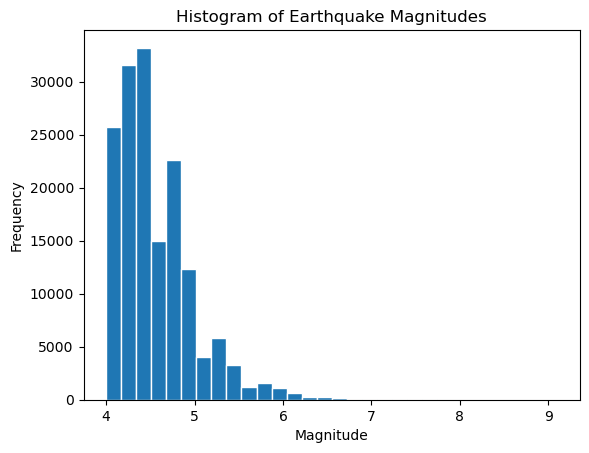

In [12]:
## Make a figure
plt.figure()

## Plot a histogram of earthquake magnitudes, using bins=30, edgecolor='white'
plt.hist(EQ_data['Magnitude'], bins=30, edgecolor='white')

## Label the axes and add a title
plt.xlabel('Magnitude')
plt.ylabel('Frequency')
plt.title('Histogram of Earthquake Magnitudes')

plt.show()

There are so many small earthquakes that we can't even see a bin for the Tohoku quake. 

Let's make the histogram on a log-scale. 

For any function, we can put a question mark after it to get its docstring. Let's do this for `plt.hist()`. 

Once you execute the cell below, you will see that there are a lot of options (which you can also view here: https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html). 

One of the options is to make the plot be on a log scale by setting `log=True`.

In [13]:
?plt.hist

Signature:
plt.hist(
    x,
    bins=None,
    range=None,
    density=False,
    weights=None,
    cumulative=False,
    bottom=None,
    histtype='bar',
    align='mid',
    orientation='vertical',
    rwidth=None,
    log=False,
    color=None,
    label=None,
    stacked=False,
    *,
    data=None,
    **kwargs,
)
Docstring:
Compute and plot a histogram.

This method uses `numpy.histogram` to bin the data in *x* and count the
number of values in each bin, then draws the distribution either as a
`.BarContainer` or `.Polygon`. The *bins*, *range*, *density*, and
*weights* parameters are forwarded to `numpy.histogram`.

If the data has already been binned and counted, use `~.bar` or
`~.stairs` to plot the distribution::

    counts, bins = np.histogram(x)
    plt.stairs(counts, bins)

Alternatively, plot pre-computed bins and counts using ``hist()`` by
treating each bin as a single point with a weight equal to its count::

    plt.hist(bins[:-1], bins, weights=counts)

The data input

- Make a histogram of the Earthquake magnitude data on a log-scale

Set `log=True` within the `plt.hist` function.

Let's make sure that this figure has labeled axes using `plt.xlabel()` and `plt.ylabel()` and we can add a title as well using `plt.title()`

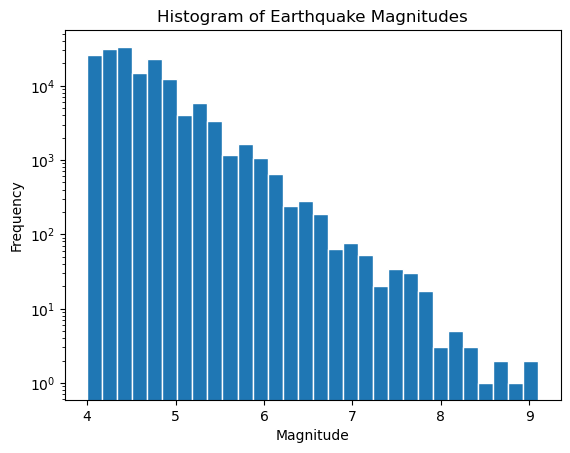

In [14]:
## Make a figure
plt.figure()

## Plot a histogram of earthquake magnitudes, using bins=30, edgecolor='white', log=True
plt.hist(EQ_data['Magnitude'], bins=30, edgecolor='white', log=True)

## Label the axes and add a title
plt.xlabel('Magnitude')
plt.ylabel('Frequency')
plt.title('Histogram of Earthquake Magnitudes')

plt.show()

### 2.2 Earthquake depth

Let's see the range and frequency of depths where earthquakes occur. 

Make a histogram of earthquake depth. Remember to set `log=True` within the `plt.hist` function.

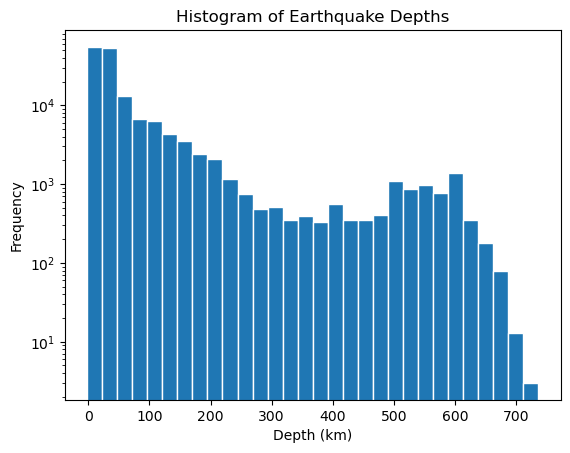

In [15]:
## Make a figure
plt.figure()

## Plot a histogram of earthquake depths, using bins=30, edgecolor='white', log=True
plt.hist(EQ_data['Depth'], bins=30, edgecolor='white', log=True)

## Label the axes and add a title
plt.xlabel('Depth (km)')
plt.ylabel('Frequency')
plt.title('Histogram of Earthquake Depths')

plt.show()

Questsion: At what depth are the majority of earthquakes? How deep do they extend? How does that compare to the typical depth of the lithosphere (~100 km)?

The map we made above is nice, but it doesn't tell us everything about our data. Let's create a map of the earthquake epicenters that colors the points by depth.

To do this, use the same `plt.scatter()` function, but add the option to set the color by depth. You can do this by having  `c=EQ_data['Depth']` within the function. 

You can customize the output by setting the minimum value for the color bar `vmin=0` and the maximum value `vmax=200`. 

You can also customize the colormap. A perceptually uniform sequential color map like `cmap='magma_r'` works well (https://matplotlib.org/tutorials/colors/colormaps.html). 

It is also nice to make the points partially see through by setting `alpha=0.5`. 

All of these customizations can be made by adding these arguments within the `plt.scatter()` function.

Make a map that colors points by depth by inserting these arguments in the `plt.scatter()` function in the code block below.

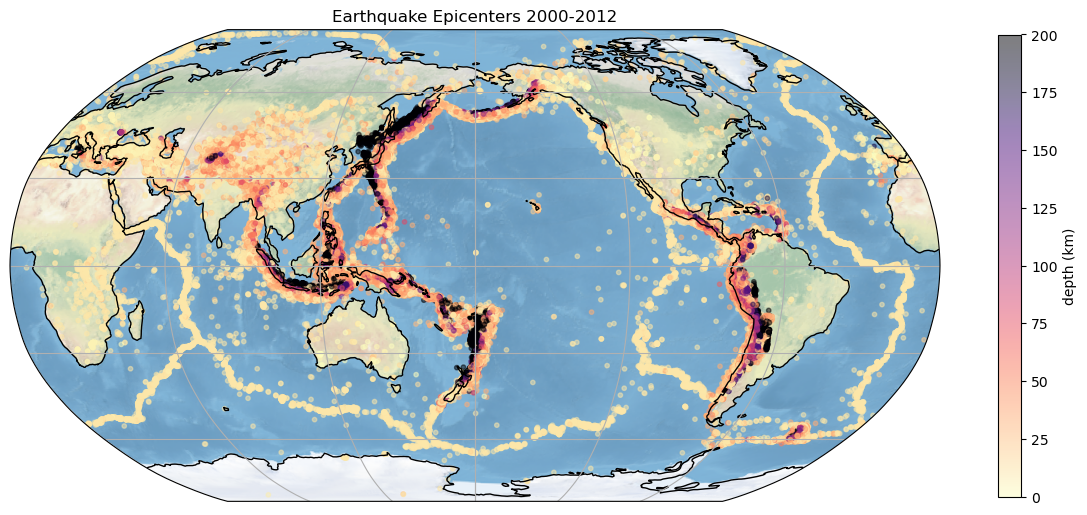

In [16]:
## Make a figure
fig = plt.figure(figsize=(15,15))

## Set the projection using ccrs.Robinson(central_longitude=180)
ax = plt.axes(projection=ccrs.Robinson(central_longitude=180))
ax.set_global()

## Plot the epicenters of the earthquakes, using c=EQ_data['Depth'], s=10, vmin=0,vmax=200,cmap='magma_r',alpha=0.5
plt.scatter(EQ_data['Longitude'],EQ_data['Latitude'], c=EQ_data['Depth'], s=10,
            vmin=0,vmax=200,cmap='magma_r',alpha=0.5,transform=ccrs.PlateCarree())

## Add coastlines, stock image, and gridlines
ax.coastlines()
ax.stock_img()
ax.gridlines()

## Add a colorbar
plt.colorbar(shrink=0.4, label='depth (km)')

## Add a title
plt.title('Earthquake Epicenters 2000-2012')

plt.show()

Question: What depth of earthquakes occur at mid-ocean ridges?

Question: What depth of earthquakes occur at trenches?

<img src="images/slab_eq.png" width=50%>

> Source: Fundamentals of Geophysics (2nd Edition) Lowrie, W.

<img src="images/slab_eq2.png" width=50%>

> A cross-section through a subduction zone. Red points are earthquake focus points. The most active region is the zone of contact between the plates. There is a back-arc seismic zone in the overriding plate. Below ~70 km depth earthquakes occur within the subducting plate, this region is call the Wadati-Benioff seismic zone.

The earthquakes at trenches (like around the Pacific ocean's 'ring of fire') get deeper in a systematic way. The deepest earthquakes are the farthest from the trench. This reveals the location of the downgoing slabs.

- The Andean subduction zone

Let's look at a subset of this earthquake catalog across the Andes in South America. The code below is filtering the data frame to only include those between 20ºS and 25ºS latitude and 75ºW and 60ºW longitude.

In [17]:
## Filter the data frame to only include those between 20ºS and 25ºS latitude and 75ºW and 60ºW longitude
min_lat = -25
max_lat = -20
min_lon = -75
max_lon = -60 

selected_quakes = EQ_data[
        (EQ_data['Latitude']>min_lat) & (EQ_data['Latitude']<max_lat) &
        (EQ_data['Longitude']>min_lon) & (EQ_data['Longitude']<max_lon)
    ]

Let's make a map of the epicenters of these earthquakes following the same procedure as we did above.

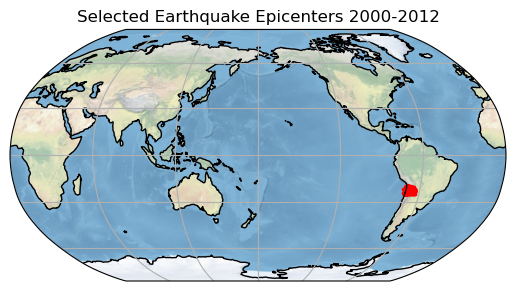

In [18]:
## Make a figure
plt.figure()

## Set the projection using ccrs.Robinson(central_longitude=180)
ax = plt.axes(projection=ccrs.Robinson(central_longitude=180))
ax.set_global()

## Plot the epicenters of the earthquakes, using s=10, marker='.', color='red'
plt.scatter(selected_quakes['Longitude'],selected_quakes['Latitude'],s=10, marker='.',color='red',transform=ccrs.PlateCarree())

## Add coastlines, stock image, and gridlines
ax.coastlines()
ax.stock_img()
ax.gridlines()

## Add a title
plt.title('Selected Earthquake Epicenters 2000-2012')    

plt.show()

Let's take all of the earthquakes within that region and plot earthquake depth on the y-axis and earthquake location on the x-axis. 

Labeling axes is super important in science! Don't make plots without labeled axes!

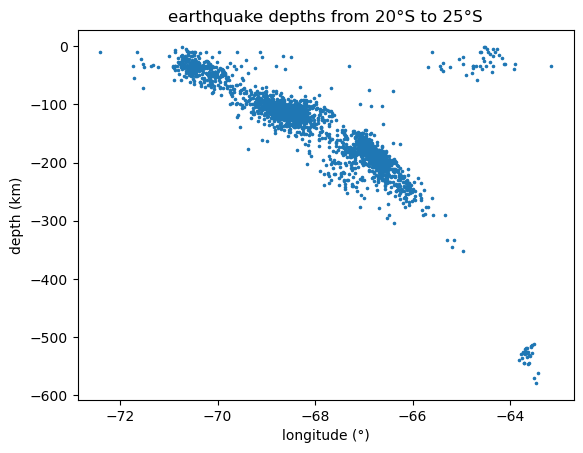

In [19]:
## Make a figure
plt.figure()

## Plot the epicenters of the earthquakes, using longitude on the x-axis and depth on the y-axis, using s=10, marker='.'. 
## Hint: Using -selected_quakes['Depth'] to plot deeper earthquakes lower on the y-axis
plt.scatter(selected_quakes['Longitude'], -selected_quakes['Depth'], s=10, marker='.')

## Label the axes and add a title
plt.xlabel('longitude (°)')
plt.ylabel('depth (km)')
plt.title('earthquake depths from 20°S to 25°S')

plt.show()

- Japan subduction

Let's look at the subduction zone off the east coast of Japan. 

Please find the correct latitude and longitude range for this region and plot the earthquakes on a map and make a similar depth vs. longitude plot (or depth vs latitude plot) for another region.

In [20]:
# Define the latitude and longitude range
min_lat = 32
max_lat = 43
min_lon = 135
max_lon = 145

selected_quakes = EQ_data[
        (EQ_data['Latitude']>min_lat)&(EQ_data['Latitude']<max_lat)&
        (EQ_data['Longitude']>min_lon)&(EQ_data['Longitude']<max_lon)
    ]

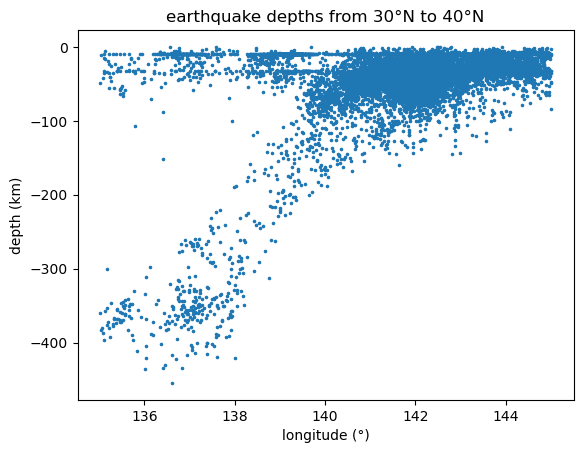

In [21]:
## Make a figure
plt.figure()

## Plot the epicenters of the earthquakes, using longitude on the x-axis and depth on the y-axis, using s=10, marker='.'. 
## Hint: Using -selected_quakes['Depth'] to plot deeper earthquakes lower on the y-axis
plt.scatter(selected_quakes['Longitude'], -selected_quakes['Depth'], s=10, marker='.')

## Label the axes and add a title
plt.xlabel('longitude (°)')
plt.ylabel('depth (km)')
plt.title('earthquake depths from 30°N to 40°N')

plt.show()

Question: What direction is subduction occuring below South America and Japan? Are they towards the east or west?


### 2.3 Relationship between earthquake location and plate boundaries

In stead of using the prepared earthquake catalog, let's use the USGS API to import a global earthquake catalog (Magnitude >= 6.0).

This can be very useful if you want to get the latest earthquake data.

- Load the earthquake data from the USGS API

Update the start_day and end_day (from 2010-01-01 to 2025-01-01) to get a query url that will return earthquakes that occured over the past 10 years.

In [22]:
## Define the start and end day from 2010-01-01 to 2025-01-01 and the minimum magnitude = 6.0
start_day = '2010-01-01'
end_day = '2025-01-01'
min_magnitude = 6.0

## Define the standard url
standard_url = 'https://earthquake.usgs.gov/fdsnws/event/1/query?format=csv&orderby=magnitude'

## Define the query url
query_url = f"{standard_url}&starttime={start_day}&endtime={end_day}&minmagnitude={min_magnitude}"

## Read the data from the query url into a dataframe
earthquake_data = pd.read_csv(query_url)

## Print the first 5 rows of the dataframe
earthquake_data.head()

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,updated,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource
0,2011-03-11T05:46:24.120Z,38.2970,142.3730,29.00,9.1,mww,541.0,9.5,NaN,1.16,...,2023-07-06T06:05:00.045Z,"2011 Great Tohoku Earthquake, Japan",earthquake,NaN,NaN,NaN,NaN,reviewed,us,official
1,2010-02-27T06:34:11.530Z,-36.1220,-72.8980,22.90,8.8,mww,454.0,17.8,NaN,1.09,...,2024-10-02T00:49:31.181Z,"36 km WNW of Quirihue, Chile",earthquake,NaN,9.2,NaN,NaN,reviewed,us,official
2,2012-04-11T08:38:36.720Z,2.3270,93.0630,20.00,8.6,mw,499.0,16.6,NaN,1.33,...,2024-06-03T22:53:23.410Z,off the west coast of northern Sumatra,earthquake,NaN,NaN,NaN,NaN,reviewed,us,official
3,2015-09-16T22:54:32.860Z,-31.5729,-71.6744,22.44,8.3,mww,NaN,19.0,0.684,1.02,...,2024-09-16T20:39:22.152Z,"48 km W of Illapel, Chile",earthquake,4.7,3.2,NaN,NaN,reviewed,us,us
4,2013-05-24T05:44:48.980Z,54.8920,153.2210,598.10,8.3,mww,385.0,10.0,NaN,1.02,...,2022-08-28T07:25:50.955Z,Sea of Okhotsk,earthquake,NaN,4.1,NaN,NaN,reviewed,us,us


- Plotting the plate boundaries and earthquake locations together

In addition to plotting the earthquake locations, we can plot the location of plate boundaries. 

I took the plate boundaries provided by the US Geological Survey (USGS) and split them by their categorization into trenches (subduction zones), ridges (spreading centers) and transform (strike-slip boundaries like the San Andreas fault).

The code below makes a map where these different plate boundaries are represented by different color lines. Please add the earthquake locations to this map as well.

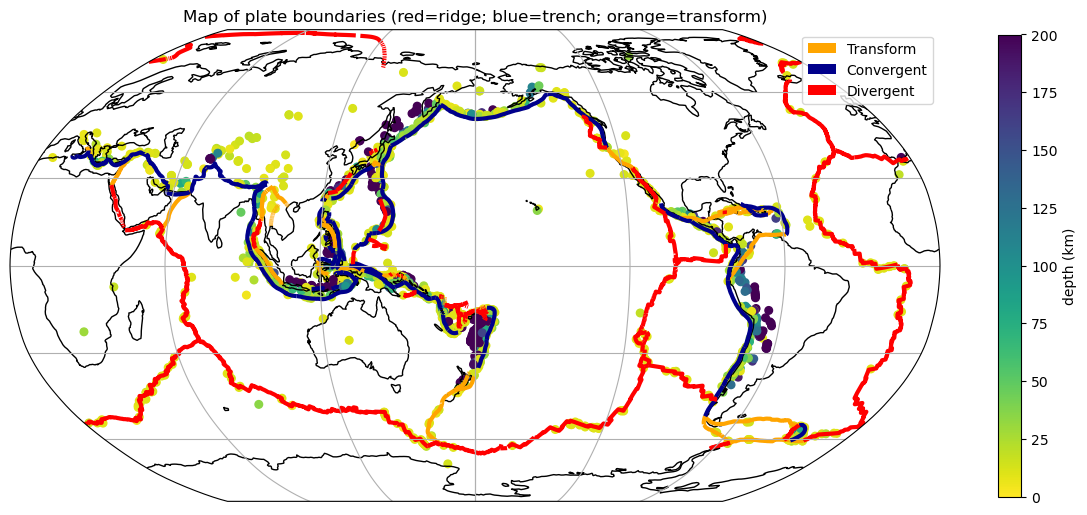

In [23]:
## Make a figure
plt.figure(figsize=(15,15))

## Set the projection using ccrs.Robinson(central_longitude=180)
ax = plt.axes(projection=ccrs.Robinson(central_longitude=180))
ax.set_global()

## Add coastlines, stock image, and gridlines
ax.coastlines()
ax.gridlines()

## Read the data from the shapefile
data = Reader('./data/Plate_Boundaries_transform.shp')

## Add the transform plate boundaries to the map
ax.add_geometries(data.geometries(), crs=ccrs.PlateCarree(), 
                  edgecolor='orange', facecolor='none',
                  linewidth=3)

## Read the data from the shapefile
data = Reader('./data/Plate_Boundaries_trenches.shp')

## Add the trench plate boundaries to the map
ax.add_geometries(data.geometries(), crs=ccrs.PlateCarree(), 
                  edgecolor='darkblue', facecolor='none',
                  linewidth=3)

## Read the data from the shapefile
data = Reader('./data/Plate_Boundaries_ridges.shp')

## Add the ridge plate boundaries to the map
ax.add_geometries(data.geometries(), crs=ccrs.PlateCarree(), 
                  edgecolor='red', facecolor='none',
                  linewidth=3)

## Make patches to add to a legend
trans = mpatches.Rectangle((0, 0), 1, 1, facecolor="orange")
con = mpatches.Rectangle((0, 0), 1, 1, facecolor="darkblue")
div = mpatches.Rectangle((0, 0), 1, 1, facecolor="red")
labels = ['Transform','Convergent','Divergent']
plt.legend([trans, con, div], labels)

## Add a title
plt.title('Map of plate boundaries (red=ridge; blue=trench; orange=transform)')

## Plot the earthquake locations on the map
plt.scatter(earthquake_data['longitude'],earthquake_data['latitude'], c=earthquake_data['depth'], s=30,
            vmin=0,vmax=200,cmap='viridis_r',transform=ccrs.PlateCarree())

plt.colorbar(shrink=0.4, label='depth (km)')

plt.show()

Question: Where do the majority of earthquakes occur?

Question: What do those locations correspond with? Trenches, ridges, or transform boundaries?


## 3. Analyze an Earthquake Seismogram

An interesting earthquake in 2020 occured 100km SSE of Perryville, Alaska at 55.0683°N 158.5543°W and was a magnitude 7.8 event.

<img src="https://raw.githubusercontent.com/zhuwq0/images/main/T5sX3oGmJpkLtVxmUzSWyM-998-80.jpg.webp" width=30%>

You can find more information about this earthquake on the USGS website: https://earthquake.usgs.gov/earthquakes/eventpage/us7000asvb/executive

Let's make a map of the earthquake location and the location of the Columbia College, Columbia, CA, USA seismic station that recorded a seismograph we will be analyzing.

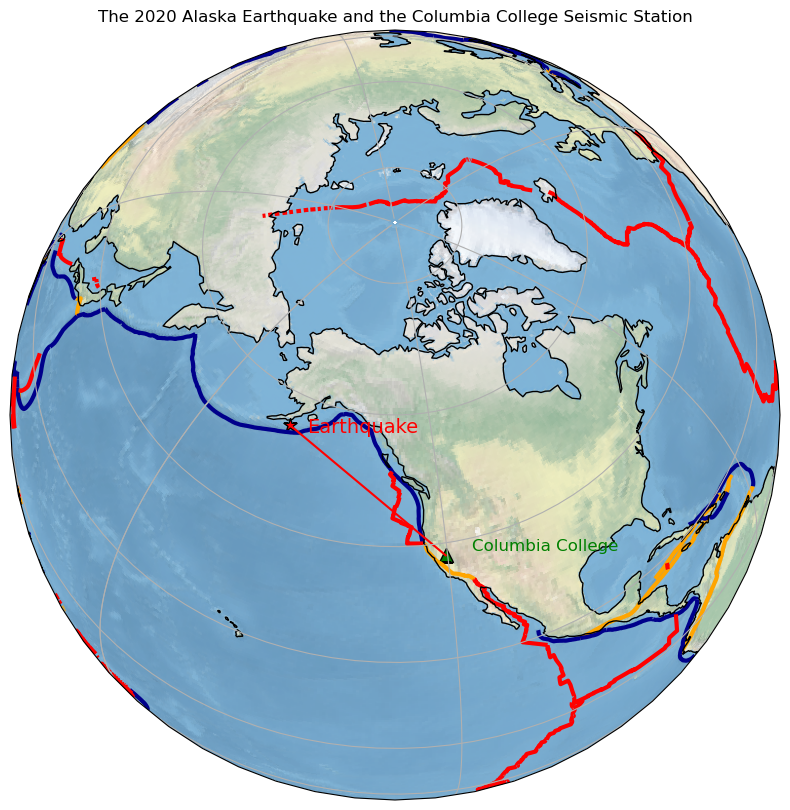

In [24]:
## Define the earthquake location of the 2020 Alaska earthquake
Earthquake_lat = 55.0683
Earthquake_lon = -158.5543

# Define the station location at Columbia College, Columbia, CA, USA
station_lat = 38.03455
station_lon = -120.38651

## Make a figure
plt.figure(1,(10,10))

## Set the projection using ccrs.Orthographic(central_longitude=-130,central_latitude=60)
ax = plt.axes(projection=ccrs.Orthographic(central_longitude=-130,central_latitude=60))
ax.set_global()

## Read the data from the shapefile
data = Reader('./data/Plate_Boundaries_transform.shp')

## Add the transform plate boundaries to the map
ax.add_geometries(data.geometries(), crs=ccrs.PlateCarree(), 
                  edgecolor='orange', facecolor='none',
                  linewidth=3)

## Read the data from the shapefile
data = Reader('./data/Plate_Boundaries_trenches.shp')

## Add the trench plate boundaries to the map
ax.add_geometries(data.geometries(), crs=ccrs.PlateCarree(), 
                  edgecolor='darkblue', facecolor='none',
                  linewidth=3)

## Read the data from the shapefile
data = Reader('./data/Plate_Boundaries_ridges.shp')

## Add the ridge plate boundaries to the map
ax.add_geometries(data.geometries(), crs=ccrs.PlateCarree(), 
                  edgecolor='red', facecolor='none',
                  linewidth=3)

## Plot the earthquake location on the map
plt.scatter(Earthquake_lon,Earthquake_lat,s=100,marker='*',
            color='red', edgecolor='black',transform=ccrs.PlateCarree())

## Add a text annotation for the earthquake location
plt.text(Earthquake_lon+5,Earthquake_lat,'Earthquake',fontsize=14,color='red',
         transform=ccrs.PlateCarree())

## Plot the seismic station location on the map
plt.scatter(station_lon,station_lat,s=100,marker='^',
            color='green', edgecolor='black',transform=ccrs.PlateCarree())

## Add a text annotation for the seismic station location
plt.text(station_lon+5,station_lat,'Columbia College',fontsize=12,color='green',
         transform=ccrs.PlateCarree())

## Plot the line connecting the earthquake and the seismic station
plt.plot([Earthquake_lon,station_lon],[Earthquake_lat,station_lat],
         color='red',transform=ccrs.Geodetic())

## Add coastlines, stock image, and gridlines
ax.coastlines()
ax.stock_img()
ax.gridlines()

## Add a title
plt.title('The 2020 Alaska Earthquake and the Columbia College Seismic Station')

plt.show()

Question: At what type of plate boundary did this earthquake occur?


More geologic context about this quake can be found here: https://www.iris.edu/hq/files/programs/education_and_outreach/retm/tm_200722_alaska/200722_Alaska.pdf

### 3.1 Distance between seismograph and earthquake

We can use the Geopy Python package to calculate the distance between the earthquake and the seismic station. 

The module `distance` of the `geopy` library was  imported at the beginning of this notebook. 

You can use `distance.distance(location1, location2)` function where each location is (latitude,longitude).

You can read more about this function here: https://geopy.readthedocs.io/en/stable/index.html?highlight=distance#module-geopy.distance

In the code cell below, define the locations, use the `distance.distance()` function to calculate the distance, and then assign the value (in km) to a variable called `earthquake_seismograph_distance_km`.

In [25]:
## define the seismic station location (latitude, longitude)
seismic_station_location = (station_lat, station_lon)

## define the earthquake location (latitude, longitude)
earthquake_location = (Earthquake_lat, Earthquake_lon) 

## calculate the distance between the earthquake and the seismic station. Hint: using distance.distance(location1, location2).km
earthquake_seismograph_distance_km = distance.distance(seismic_station_location, earthquake_location).km

print(f'The distance between the earthquake and the seismic station is {earthquake_seismograph_distance_km:.2f} km')

The distance between the earthquake and the seismic station is 3421.92 km


### 3.2 Load a Seismogram of this Earthquake


Let's load the .csv (Comma Separated Variable) data file of this seismogram as recorded at the Columbia College, Columbia, CA, USA seismic station. 

Samples were taken every 0.025 seconds (40 Hz) and the record starts 60 seconds before the arrival of the first wave which is called the P wave. 

https://www.iris.edu/app/station_monitor/#2020-07-22T06:12:44/BK-CMB/webicorder/BK-CMB%7C11273635

In [26]:
## Read the seismogram data
seismogram = pd.read_csv('./data/BK.CMB.00.BHZ.Q.2020-07-22T061756.019538.csv', header=9, names=['Time','Sample'])

## Preview format of the seismogram data
seismogram.head()

,Time,Sample
0,2020-07-22T06:17:56.044538Z,-2210
1,2020-07-22T06:17:56.069538Z,-2244
2,2020-07-22T06:17:56.094538Z,-2267
3,2020-07-22T06:17:56.119538Z,-2258
4,2020-07-22T06:17:56.144538Z,-2203


Let's take a look at the seismogram data.

The `seismogram['Time']` column is a time series of the time of the samples. We need to convert this to a datetime object using `pd.to_datetime()`.

The `seismogram['Sample']` column is a time series of the velocity of the ground motion at the location of the seismic station due to this earthquake. 

In [27]:
## Extract time from seismogram dataframe and assign to time variable. 
time = seismogram['Time']

## Use pd.to_datetime() to convert the time series to a datetime object
time = pd.to_datetime(time)

## Earthquake origin time from USGS: https://earthquake.usgs.gov/earthquakes/eventpage/us7000asvb/executive
earthquake_origin_time = pd.to_datetime("2020-07-22T06:12.44Z")

## Calculate the travel time in minutes
traveltime = (time - earthquake_origin_time).dt.total_seconds() / 60

## Extract velocity from seismogram dataframe and assign to velocity variable
velocity = seismogram['Sample']


Let's plot the seismogram with `time` on the x-axis and `velocity` on the y-axis. 

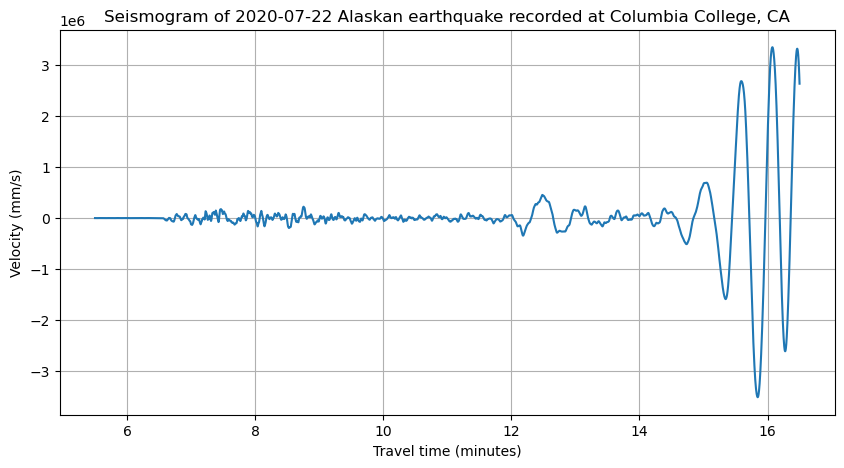

In [28]:

## Make a figure with a size of 10x5
plt.figure(figsize=(10,5))

## Plot the seismogram between the travel time and velocity
plt.plot(traveltime, velocity)

## Add x-axis label and y-axis label
plt.xlabel('Travel time (minutes)')
plt.ylabel('Velocity (mm/s)')

## Add a title
plt.title('Seismogram of 2020-07-22 Alaskan earthquake recorded at Columbia College, CA')

## Add gridlines
plt.grid(True)

plt.show()

Seismographs record the arrival of multiple types of waves. P (primary) waves are compressional waves that arrive first. S (secondary/shear) waves are shear waves that arrive next as illustrated in the example seismograph below. 

Following the P and S waves are the high amplitude surface waves:

# <img src="images/seis_wave_travel_time.png" width="50%">

Let's see from the P and S wave arrival times on the seismograph, if we can determine the distance to the earthquake.

To do this, we need to pick the arrival time of the S wave. From the seismograph, read the travel time of the P and S waves.

Assign the travel time of the P wave to a variable called `p_wave_travel_time` and the travel time of the S wave to a variable called `s_wave_travel_time`.

In [29]:
p_wave_travel_time = 6.6 #minutes                         
s_wave_travel_time = 12.0 #minutes

Let's plot the seismograph with annotations for the P and S wave arrivals to see if your picks are correct.

Using the annotations, we can indicate when the P wave arrived and when the S wave arrived on the seismograph. Take your code from above that plots the seismograph and add this code to also plot annotations:

```
ax.annotate('P wave', (mdates.date2num(time[psamp]), velocity[psamp]), xytext=(-10, 35), 
            textcoords='offset points', arrowprops=dict(arrowstyle='-|>'))
ax.annotate('S wave', (mdates.date2num(time[ssamp]), velocity[ssamp]), xytext=(-10, 35), 
            textcoords='offset points', arrowprops=dict(arrowstyle='-|>'))
```


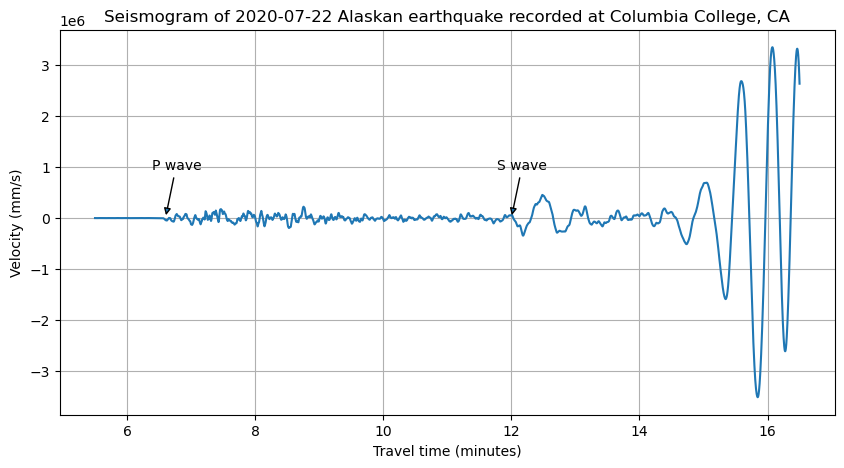

In [30]:
## Make a figure with a size of 10x5
plt.figure(figsize=(10,5))
## Plot the seismograph
plt.plot(traveltime, velocity)

## Plot the P wave annotation
plt.annotate('P wave', (p_wave_travel_time, 0), xytext=(-10, 35), 
            textcoords='offset points', arrowprops=dict(arrowstyle='-|>'))

## Plot the S wave annotation
plt.annotate('S wave', (s_wave_travel_time, 0), xytext=(-10, 35), 
            textcoords='offset points', arrowprops=dict(arrowstyle='-|>'))

## Add x-axis label and y-axis label
plt.xlabel('Travel time (minutes)')
plt.ylabel('Velocity (mm/s)')

## Add a title
plt.title('Seismogram of 2020-07-22 Alaskan earthquake recorded at Columbia College, CA')

## Add gridlines
plt.grid(True)

plt.show()


If your picks are not correct, go back up and adjust the P and S wave arrival times until you are happy with them.

Once you have made this plot, go back up and adjust the S wave arrival time (which is with respect to the start of the record in fractional minutes). Keep adjusting that value and moving you S wave arrival pick until it as at a spot in the record that you feel happy with. You should be looking for when the record transitions from the amplitude charecteristic of the P wave to a higher amplitude (but an amplitude that is still significantly less than that associated with the surface waves). Look at the example above for guidance.

**Keep adjusting and rerunning the code until you are happy with the S wave pick**

Once you have your s wave pick subtract the `p_wave_travel_time` from the `s_wave_travel_time` and assign that difference to a variable ```seismogram_s_p_difference``` in the code cell below:

In [31]:
seismogram_s_p_difference = s_wave_travel_time - p_wave_travel_time

- Estimate distance based on S-P time difference

The difference in P and S wave arrival times can be used to determine the distance from the recording station to the earthquake using a travel time curve if we know the velocities of the waves through the Earth.  So first we need to know how these two waves behave — particularly their velocities. Check out this short video demonstration:

https://www.iris.edu/hq/inclass/uploads/videos/A_6_seismictraveltimeirisbounc.mp4

https://www.iris.edu/hq/inclass/animation/traveltime_curves_how_they_are_created

Calculated travel times based on a standard earth models are in the the data folder as `arrival_times.csv`. The time unit is minutes. Let's import them as a dataframe.

In [32]:
## Read the travel time table
travel_time_table = pd.read_csv('./data/arrival_times.csv')

## Preview the travel time table
travel_time_table.head()

,degrees_from_quake,P_wave_time,S_wave_time
0,0.0,0.090000,0.156667
1,0.5,0.176667,0.306667
2,1.0,0.295000,0.520000
3,1.5,0.410000,0.726667
4,2.0,0.523333,0.930000


We will use the S-P time difference to estimate the distance between the earthquake and the seismograph. 

So let's create a new column in the travel time table that is the S-P time difference. We want distance in km, so we need to convert the degrees to km.

To convert the degrees to km, we need to know the radius of the Earth. The radius of the Earth is 6371 km.

The circumference of the Earth is $2\pi r$ for 360 degrees, so 1 degree is $2\pi r / 360$ km.


In [33]:
## Create a new column in the travel time table that is the S-P time difference
travel_time_table['S-P_difference'] = travel_time_table['S_wave_time'] - travel_time_table['P_wave_time']

## Convert the degrees to km
radius_earth = 6371
degrees_to_km = 2 * np.pi * radius_earth / 360
travel_time_table['distance_km'] = travel_time_table['degrees_from_quake'] * degrees_to_km


Let's plot the S-P time difference vs distance in km from the earthquake.


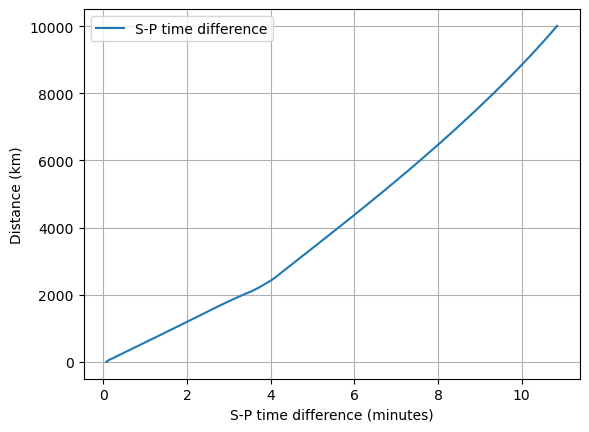

In [34]:
plt.figure()

## Plot the S-P time difference
plt.plot(travel_time_table['S-P_difference'], travel_time_table['distance_km'], label='S-P time difference')

## Add x-axis label and y-axis label
plt.ylabel('Distance (km)')
plt.xlabel('S-P time difference (minutes)')

## Add legend and grid
plt.legend()
plt.grid()

plt.show()

Based on the timetable between S-P time difference and distance, we can build a linear relationship between the two. 

The model will take the S-P time difference as input and return the distance as output.


The model R-squared is 0.98


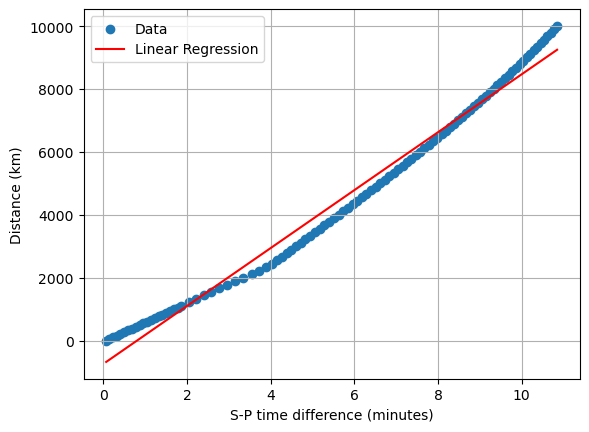

In [35]:
## Define the input and output variables. Hint: use the `[[]]` to extract S-P time difference as a column. And add `.values` to convert to a numpy array
X = travel_time_table[['S-P_difference']].values
y = travel_time_table[['distance_km']].values

## Fit a linear model using LinearRegression() from sklearn
model = LinearRegression()
model.fit(X, y)

## Get prediction from the model
y_pred = model.predict(X)

## Evaluate the model using r2_score
R_squared = r2_score(y, y_pred)
print(f'The model R-squared is {R_squared:.2f}')

## Plot the prediction
plt.figure()
plt.scatter(X, y, label='Data')
plt.plot(X, y_pred, color='red', label='Linear Regression')
plt.xlabel('S-P time difference (minutes)')
plt.ylabel('Distance (km)')
plt.legend()
plt.grid()
plt.show()

Question: Is the linear relationship between the S-P time difference and distance fit the data well?


Let's see if we can add higher order terms to the model to improve the fit. 

Recall the `PolynomialFeatures` function from sklearn, which we used in the linear regression lecture.

We can use the `make_pipeline` function to add the polynomial features to the model, as we did in the logistic regression/classification lecture.


The model R-squared is 1.00


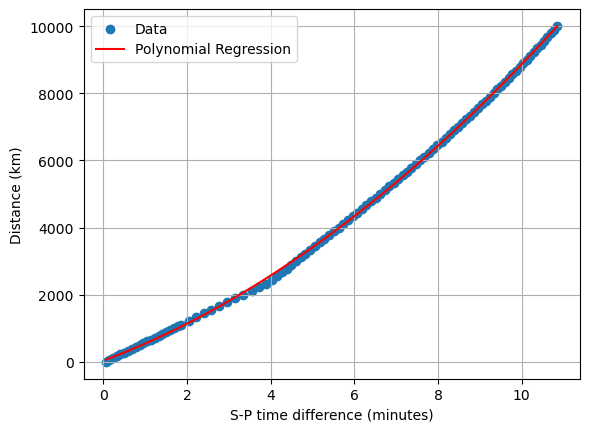

In [36]:
## Define the input and output variables. Hint: use the `[[]]` to extract S-P time difference as a column
X = travel_time_table[['S-P_difference']].values
y = travel_time_table[['distance_km']].values


## Fit a linear model using make_pipeline(PolynomialFeatures(degree=2), LinearRegression())
model = make_pipeline(PolynomialFeatures(degree=2), LinearRegression())
model.fit(X, y)

## Get prediction from the model
y_pred = model.predict(X)

## Evaluate the model using r2_score
R_squared = r2_score(y, y_pred)
print(f'The model R-squared is {R_squared:.2f}')

## Plot the prediction
plt.figure()
plt.scatter(X, y, label='Data')
plt.plot(X, y_pred, color='red', label='Polynomial Regression')
plt.xlabel('S-P time difference (minutes)')
plt.ylabel('Distance (km)')
plt.legend()
plt.grid()
plt.show()

It seems that the polynomial model fits the data better than the linear model, resulting in a higher R-squared value.

Now we can use the polynomial model to estimate the distance between the earthquake and the seismograph based on the S-P time difference you picked.

In [37]:
## Use the model to predict the distance. Hint: use the `[[ ]]` to pass in the S-P time difference as a vertical array
distance_km = model.predict([[seismogram_s_p_difference]])

## Print the estimated distance
print(f'The estimated distance is {distance_km[0][0]:.2f} km')


The estimated distance is 3777.23 km


From reading the seismograph, you can successfully pick the P and S wave arrival times and use them to estimate the distance to the earthquake.

How does the estimate of distance compare to the true earthquake epicenter distance that you calculated using the `geopy` `distance.distance()`? 

If the errors are within 15%, you did a good job picking the P and S wave arrival times.
If they are very different you may want to reconsider your P and S wave arrival times and recompute.

In the above example, we only used one seismograph station to estimate the distance to the earthquake. In practice, we use data from many stations to estimate the earthquake location.

The earthquake locations that we used in the first part of the assignment are determined thorugh computing the distance from the earthquake for at least three stations as illustrated below. 

With three stations, we can form a triangle and determine the location of the earthquake by finding the point that is equidistant from all three stations.

<img src="images/IRIS_eq_tri.png">

## 4. Earthquake Occurrence Statistics (Aftershocks)

In this section, we will further explore the earthquake catalog data and compute the earthquake occurrence statistics: Omori's Law and Gutenberg-Richter Law.

These information will be useful for understanding the earthquake hazard and making earthquake forecasts.

There are two primary statistics that describe earthquake catalog data. 

The first is Gutenberg-Richter, which is used to characterize the rates of primary earthquakes over some period of time to determine rates of occurence, which can then be used to assess hazard and make earthquake forecasts.

$$ log_{10}N(M) = A - b \cdot M $$

where $N(M)$ is the number of earthquakes, $M$ is the earthquake magnitude.

The second is Omori's Law which describes the distribution of aftershocks following a primary earthquake or mainshock. It can be used to estimate the rate of aftershock production over time after the earthquake.

$$ N(t) = \frac{k}{(c + t)^p} $$

<!-- $$ log_{10}N(t) = log_{10}k - p \cdot log_{10}(c + t) $$ -->

where $N(t)$ is the number of aftershocks after $t$ days, $k$ is a constant, $c$ is the time at which the aftershock production rate peaks, and $p$ is the decay rate.

<!-- - Load a Bay Area seismic catalog of January 01,1989 to December 31, 1995.
- Compute the distance and time interval between Loma Prieta quake and subsequant earthquakes to indentify aftershocks.
- Filter the aftershocks from the catalog and look at their distribution.
- Examine the Gutenberg-Richter statistic
- Make and earthquake forecast -->


Let's look at earthquakes that occurred close to Berkeley.

In particular, on October 17 at 5:15pm PDT (October 18 1989 at 04:15am UTC) the M6.9 Loma Prieta earthquake occurred in the Santa Cruz mountains approximately 80 km southwest of the Berkeley Campus. 

We will use the earthquake catalog in the Bay Area and aftershocks of the Loma Prieta earthquake to examine the earthquake statistics.

<img src="https://upload.wikimedia.org/wikipedia/commons/8/84/USGS_Shakemap_-_1989_Loma_Prieta_earthquake_%28June_1988_foreshock%29.jpg" width=30%>

https://en.wikipedia.org/wiki/1989_Loma_Prieta_earthquake

- Load the Earthquake Catalog 

Load the .csv data file of all the earthquakes from January 01,1989 to December 31, 1995 in the ANSS (Advanced National Seismic System) catalog from between latitudes 36.0-38.5° and longitude -123.0 to -121.0° ([http://ncedc.org/anss/catalog-search.html](http://ncedc.org/anss/catalog-search.html)).

In [38]:
## Load the Earthquake Catalog
catalog = pd.read_csv('data/bay_area_anss_1989_1995.csv')

## Convert the DateTime column to a datetime object
catalog['DateTime'] = pd.to_datetime(catalog['DateTime'])

## Preview the catalog
catalog.head()

,Unnamed: 0,DateTime,Latitude,Longitude,Depth,Magnitude,MagType,NbStations,Gap,Distance,RMS,Source,EventID
0,0,1989-01-01 03:51:37.170,36.5928,-121.1027,0.00,1.26,Md,4,150.0,6.0,0.13,NC,1160762.0
1,1,1989-01-01 11:39:34.870,36.9583,-121.5762,5.70,1.07,Md,34,36.0,1.0,0.08,NC,129467.0
2,2,1989-01-01 21:05:18.030,37.5293,-121.6905,7.03,0.99,Md,11,80.0,4.0,0.02,NC,129474.0
3,3,1989-01-01 21:54:27.470,37.5590,-121.6760,7.38,0.85,Md,12,66.0,1.0,0.04,NC,129475.0
4,4,1989-01-01 21:57:12.240,36.6493,-121.2678,4.66,1.17,Md,21,65.0,1.0,0.04,NC,129476.0


As usual, we will start by plotting the earthquake catalog on a map.

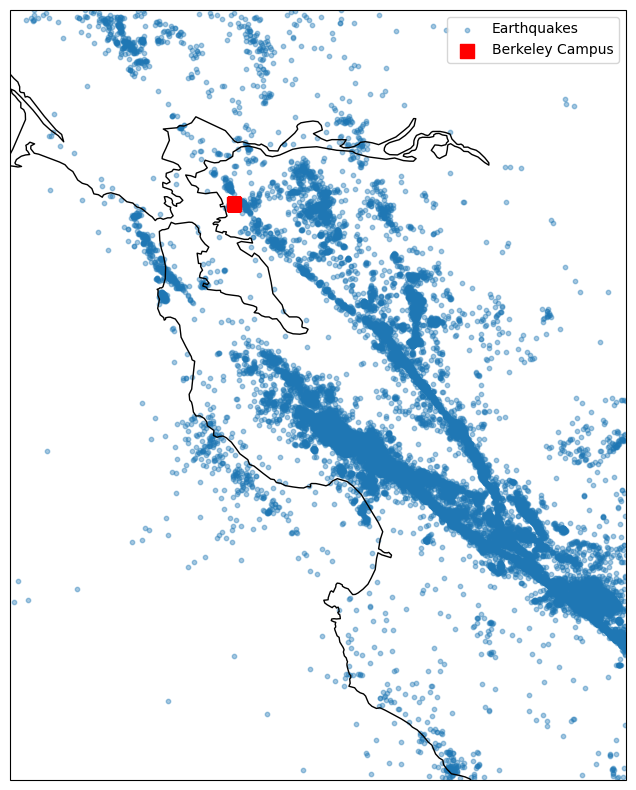

In [39]:
## Coordinates for UC Berkeley
Berk_lat = 37.8716
Berk_lon = -122.2727

## Coordinates for the map
lat0=36.0
lat1=38.5
lon0=-123.0
lon1=-121.0

## Make a map using cartopy
plt.figure(figsize=(10, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([lon0, lon1, lat0, lat1], crs=ccrs.PlateCarree())

## Plot the entire catalog
plt.scatter(catalog['Longitude'], catalog['Latitude'], s=10, alpha=0.4, label='Earthquakes')

## Add coastlines
ax.coastlines(resolution='10m',linewidth=1)

## Add Berkeley Campus. Remember to add `label='Berkeley Campus'` to the scatter plot.
plt.scatter(Berk_lon, Berk_lat, color='red', marker='s', s=100, label='Berkeley Campus')

## Add x and y labels
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

## Add legend
plt.legend()

plt.show()

- Earthquake frequency vs magnitude

Let's first look at the earthquake frequency vs magnitude for the entire catalog. 


Based on the Gutenberg-Richter Law, we expect a linear relationship between the logarithm of the number of earthquakes and the magnitude.

$$ log_{10}N(M) = A - b \cdot M $$

You can use `plt.hist()` to plot the histogram of `LP_catalog['Magnitude']`. Use `log=True` to plot the histogram on a log scale.

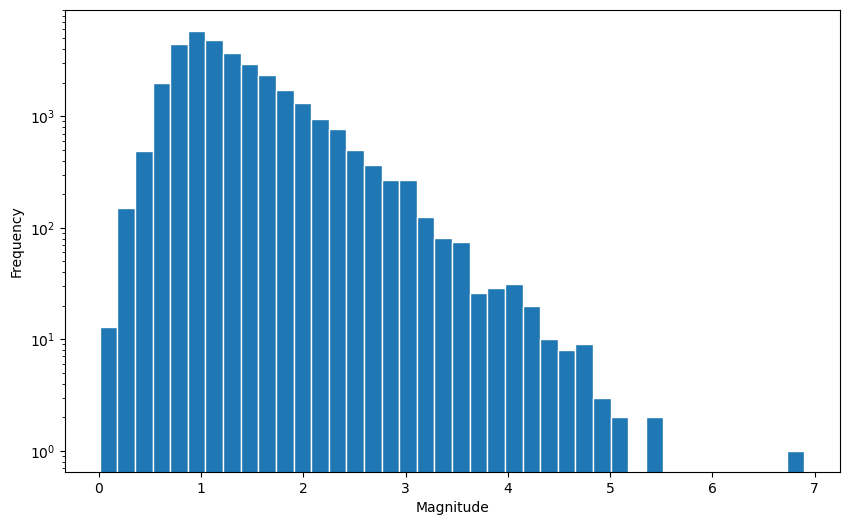

In [49]:
## Make a figure
plt.figure(figsize=(10, 6))

## Plot the histogram of earthquake frequency vs magnitude.
plt.hist(catalog['Magnitude'], bins=40, edgecolor='white')

## Set the y-axis in log scale
plt.yscale('log')

## Add x-axis label and y-axis label
plt.xlabel('Magnitude')
plt.ylabel('Frequency')

plt.show()

Question: Does the histogram follow a linear relationship? Can you approximate the slope and intercept of the linear relationship?

Let's have a more accurate estimate of the slope and intercept of the linear relationship. 

Recall the linear regression model from the lecture, let's use `LinearRegression()` to fit the data.

The model R-squared is 0.52


/var/folders/gc/lpnp82h92tv35c_7v97w97cm0000gn/T/ipykernel_61017/1003800955.py:10: RuntimeWarning: divide by zero encountered in log10
  y = np.log10(frequency)


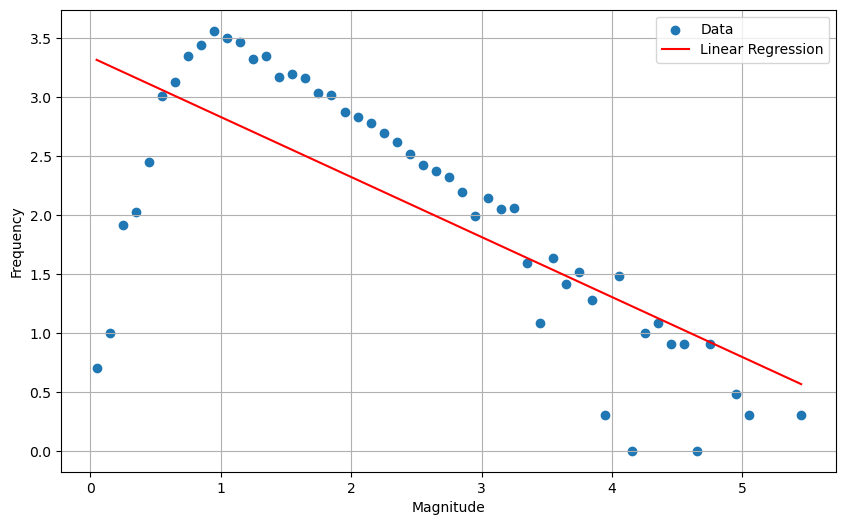

In [51]:
## We can use the np.histogram function to get the frequency of each magnitude bin. Hint: define magnitude_bins between M0 and M6 with a bin size of M0.1
magnitude_bins = np.arange(0, 6, 0.1)
frequency, _ = np.histogram(catalog['Magnitude'], bins=magnitude_bins)

## Redefine the magnitude_bins to be the bin centers, because the histogram function is using the bin edges.
magnitude_bins = (magnitude_bins[:-1] + magnitude_bins[1:]) / 2 

## Define the input and output variables. Hint: use `np.log10(frequency)` to take the logarithm of the frequency
X = magnitude_bins
y = np.log10(frequency)

## filter out the inf values
X = X[~np.isinf(y)]
y = y[~np.isinf(y)]

## Reshape the input and output variables to be vertical arrays. Hint: use the `reshape(-1, 1)` method
X = X.reshape(-1, 1)
y = y.reshape(-1, 1)

## Fit a linear model using LinearRegression() from sklearn
model = LinearRegression()
model.fit(X, y)

## Get prediction from the model
y_pred = model.predict(X)

## Evaluate the model using r2_score
R_squared = r2_score(y, y_pred)
print(f'The model R-squared is {R_squared:.2f}')

## Plot the prediction
plt.figure(figsize=(10, 6))
plt.scatter(X, y, label='Data')
plt.plot(X, y_pred, color='red', label='Linear Regression')
plt.xlabel('Magnitude')
plt.ylabel('Frequency')
plt.legend()
plt.grid()
plt.show()


Question: Does the linear model fit the data well? Pay attention to the small magnitude earthquakes.

The reason the model does not fit well at the small magnitude earthquakes (M < 1) is because the earthquake catalog is not complete for small magnitude earthquakes meaning that there are many small magnitude earthquakes that are not recorded in the catalog because of many reasons such as the earthquakes are too far away from the seismic stations, the earthquakes are too weak to be recorded by the seismographs, and the background noise level is too high for automatic algorithms to identify the earthquakes.

To fix the fit, let's only fit the data for M >= 1.


The model R-squared is 0.92


/var/folders/gc/lpnp82h92tv35c_7v97w97cm0000gn/T/ipykernel_61017/3379333328.py:10: RuntimeWarning: divide by zero encountered in log10
  y = np.log10(frequency)


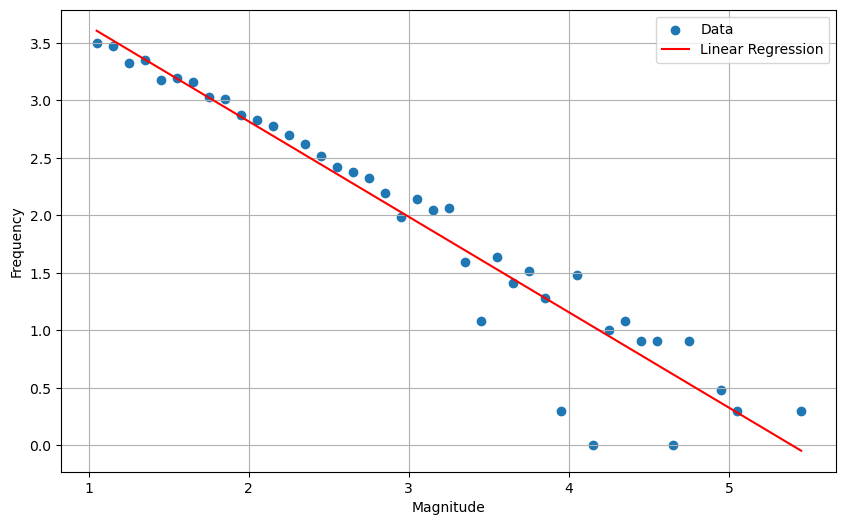

In [52]:
## We can use the np.histogram function to get the frequency of each magnitude bin. Hint: use magnitude_bins between M0 and M6 with a bin size of M0.1
magnitude_bins = np.arange(0, 6, 0.1)
frequency, _ = np.histogram(catalog['Magnitude'], bins=magnitude_bins)

## Redefine the magnitude_bins to be the bin centers, because the histogram function returns the bin edges.
magnitude_bins = (magnitude_bins[:-1] + magnitude_bins[1:]) / 2 

## Define the input and output variables. Hint: use `np.log10(frequency)` to take the logarithm of the frequency
X = magnitude_bins
y = np.log10(frequency)

## Filter the input and output variables to only include the data for M >= 1
y = y[X >= 1]
X = X[X >= 1]

## filter out the inf values
X = X[~np.isinf(y)]
y = y[~np.isinf(y)]

## Reshape the input and output variables to be vertical arrays. Hint: use `reshape(-1, 1)`
X = X.reshape(-1, 1)
y = y.reshape(-1, 1)


## Fit a linear model using LinearRegression() from sklearn
model = LinearRegression()
model.fit(X, y)

## Get prediction from the model
y_pred = model.predict(X)

## Evaluate the model using r2_score
R_squared = r2_score(y, y_pred)
print(f'The model R-squared is {R_squared:.2f}')

## Plot the prediction
plt.figure(figsize=(10, 6))
plt.scatter(X, y, label='Data')
plt.plot(X, y_pred, color='red', label='Linear Regression')
plt.xlabel('Magnitude')
plt.ylabel('Frequency')
plt.legend()
plt.grid()
plt.show()


We can now extract the slope and intercept of the linear model.

In [53]:
## Get the slope and intercept
slope = model.coef_[0][0]
intercept = model.intercept_[0]

print(f'The slope is {slope:.2f} and the intercept is {intercept:.2f}')

The slope is -0.83 and the intercept is 4.48


Question: How much does the fit improve? 

Question: What is the slope and intercept of the linear model? Can you estimate the a-value and b-value of the Gutenberg-Richter Law? 

$$ log_{10}N(M) = A - b \cdot M $$

Question: What does the b-value tell us about the earthquake catalog? If we have one earthquake of magnitude 6, how many earthquakes of magnitude 5 would we expect to have in the catalog? How about magnitude 4, 3, 2, and 1?

Let's now look at the aftershocks of the Loma Prieta earthquake.

First, we need to extract the period of the Loma Prieta earthquake.

In [44]:
## Define the earthquake origin time, latitude, and longitude (https://earthquake.usgs.gov/earthquakes/eventpage/nc216859/executive)
earthquake_origin_time = pd.to_datetime('1989-10-18 00:04:15')
earthquake_latitude = 37.036
earthquake_longitude = -121.885

## Define a new column of days since the earthquake origin time. 
catalog['days_since_earthquake'] = (catalog['DateTime'] - earthquake_origin_time).dt.days

## Extract the earthquakes within 0.1 degree from the earthquake origin and within 90 days from the earthquake origin time
LP_catalog = catalog[(catalog['days_since_earthquake'] >= 0) & 
                        (catalog['days_since_earthquake'] <= 90) & 
                        (catalog['Latitude'] >= earthquake_latitude - 0.1) & 
                        (catalog['Latitude'] <= earthquake_latitude + 0.1) & 
                        (catalog['Longitude'] >= earthquake_longitude - 0.1) & 
                        (catalog['Longitude'] <= earthquake_longitude + 0.1)]


- Plot magnitude vs. time for the aftershock events

You can try to use `s=LP_catalog['Magnitude']` to scale the marker size by magnitude, or `c=LP_catalog['Magnitude']` to color the marker by magnitude, cmap='plasma' seems to be a nice color map.

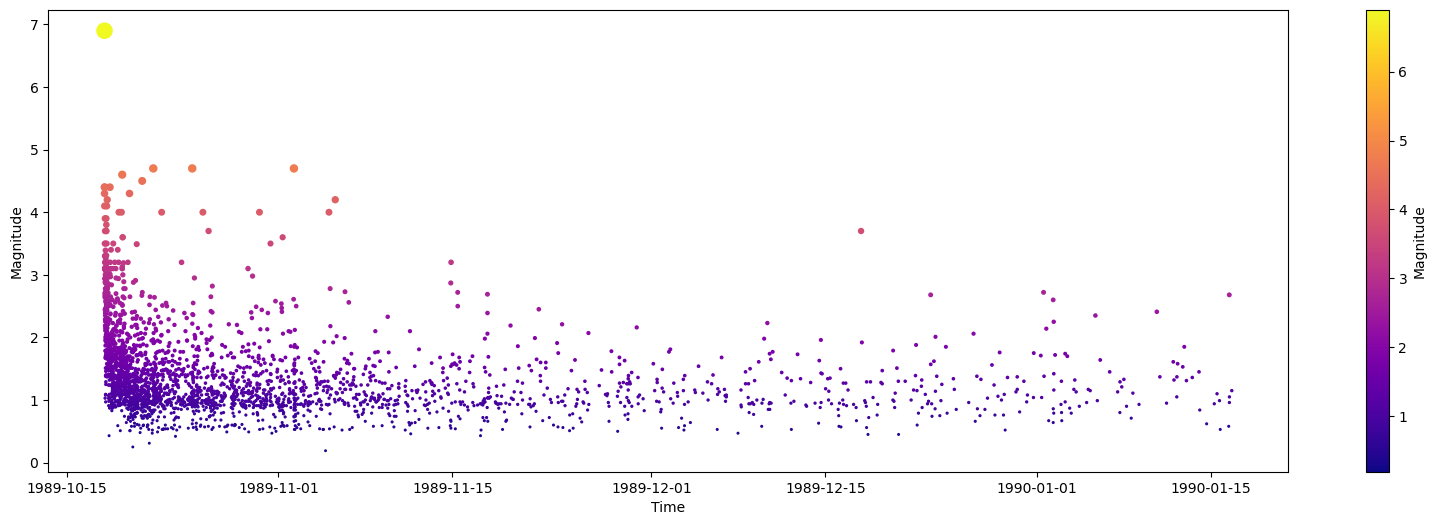

In [45]:
## Make the figure size wide using `figsize=(20, 6)`
plt.figure(figsize=(20, 6))

## Plot the Loma Prieta aftershock catalog between 'DateTime' and 'Magnitude'
plt.scatter(LP_catalog['DateTime'], LP_catalog['Magnitude'], s=2**LP_catalog['Magnitude'], c=LP_catalog['Magnitude'], cmap='plasma')

## Add a color bar
plt.colorbar(label='Magnitude')

## Add x-axis label and y-axis label
plt.xlabel('Time')
plt.ylabel('Magnitude')

plt.show()

Question: How would you describe the distribution of large earthquake magnitudes with time?

- Plot earthquake frequency vs time

You can use `plt.hist()` to plot the histogram of `days_since_earthquake`.


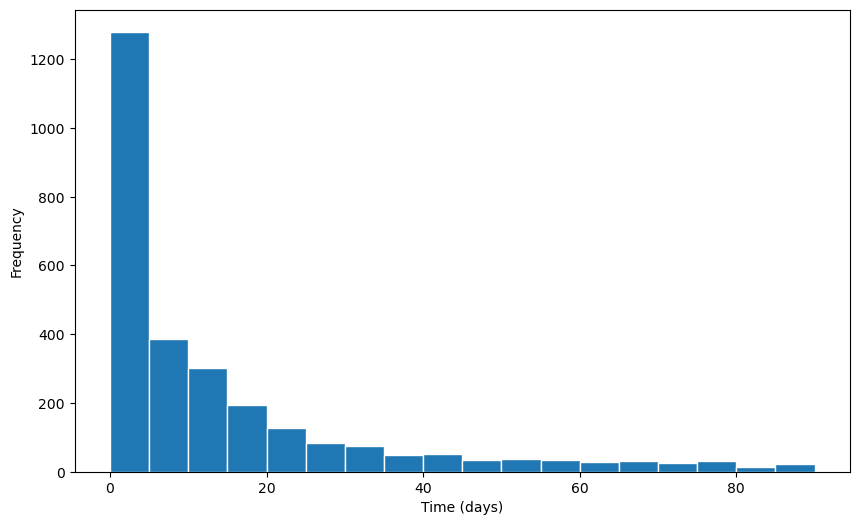

In [61]:
## Make a figure
plt.figure(figsize=(10, 6))

## Define bins from 0 to 90 days with a bin size of 5 days.
days_bins = np.arange(0, 91, 5)

## Plot the histogram of earthquake frequency vs time.)
plt.hist(LP_catalog['days_since_earthquake'], bins=days_bins, edgecolor='white')

## Add x-axis label and y-axis label
plt.xlabel('Time (days)')
plt.ylabel('Frequency')

plt.show()

Question: How would you describe the distribution of number of aftershocks with time after the main quake? What is the peak time of aftershock production? How does the aftershock rate decay with time?

Let's see if we can do some quantitative analysis of the aftershock rate decay with time.

The challenge is that the Omori's law is not a linear relationship, but a power law relationship. 

$$ N(t) = \frac{k}{(c + t)^p} $$ 

Let's first convert the equation to a linear form.

$$ log_{10}N(t) = log_{10}k - p \cdot log_{10}(c + t) $$

For simplicity let's assume `c=0` and fit the data to the linear model. 

$$ log_{10}N(t) = log_{10}k - p \cdot log_{10}(t) $$

So the y value is `log10(N(t))` and the x value is `log10(t)`.

The model R-squared is 0.97


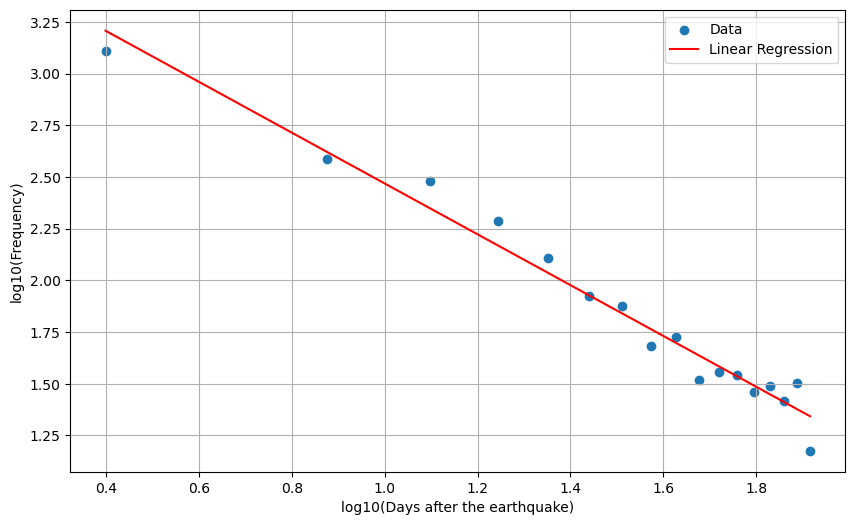

In [65]:
## Calcualte frequency of earthquakes using np.histogram. Using using days_bins between 0 and 90 days for every 5 days.
days_bins = np.arange(0, 90, 5)
frequency, bins = np.histogram(LP_catalog['days_since_earthquake'], bins = days_bins)

## Calculate the days on bin centers becuase the "bins" variable is defined as the bin edges
days_bins = (bins[:-1] + bins[1:]) / 2

## Define the input and output variables. Hint: use `np.log10(frequency)` to take the logarithm of the frequency and `np.log10(days_bins)` to take the logarithm of the days_bins
X = np.log10(days_bins)
y = np.log10(frequency)

## filter out the inf values
X = X[~np.isinf(y)]
y = y[~np.isinf(y)]

## Reshape the input and output variables to be vertical arrays
X = X.reshape(-1, 1)
y = y.reshape(-1, 1)

## Fit a linear model using LinearRegression() from sklearn
model = LinearRegression()
model.fit(X, y)

## Get prediction from the model
y_pred = model.predict(X)

## Evaluate the model using r2_score
R_squared = r2_score(y, y_pred)

print(f'The model R-squared is {R_squared:.2f}')

## Plot the prediction
plt.figure(figsize=(10, 6))
plt.scatter(X, y, label='Data')
plt.plot(X, y_pred, color='red', label='Linear Regression')
plt.xlabel('log10(Days after the earthquake)')
plt.ylabel('log10(Frequency)')
plt.legend()
plt.grid()

plt.show()


We can extract the slope and intercept of the linear model.

In [66]:
## Get the slope and intercept
slope = model.coef_[0][0]
intercept = model.intercept_[0]

print(f'The slope is {slope:.2f} and the intercept is {intercept:.2f}')

The slope is -1.23 and the intercept is 3.70


Question: How is the fit of the linear model to the aftershock data? Can you estimate the p-value of the Omori's Law?

Question: What does the decay rate $p$ tell us about the rate of aftershock production over time? If we have 1000 aftershocks in the first 5 days, how many aftershocks every 5 day peroid would we expect after 100 days?

- Earthquake recurrence in the San Francisco Bay Area

Both the Gutenberg-Richter Law and Omori's Law are very important for understanding the earthquake recurrence in a region.

Recall the lecture about probability of earthquake occurrence in [08 probability](https://ai4eps.github.io/EPS88_PyEarth/lectures/08_probabilities/#extension-earthquake-probability).

Based on the 120 year catalog, we can estimate the average recurrence interval for magnitude 5.0, 6.0, 7.0 and 8.0 events in the San Francisco Bay Area. 

The bay area is located on the San Andreas Fault, which is the boundary between the Pacific and North American tectonic plates.

You can read more information about earthquake hazard of the San Andreas Fault from the USGS website:

https://www.usgs.gov/natural-hazards/earthquake-hazards/science/back-future-san-andreas-fault?qt-science_center_objects=0#qt-science_center_objects

Although we can not predict when and where the next big earthquake will happen, understanding the earthquake recurrence can help us prepare for the earthquake and mitigate the earthquake risk.

Earthquake forecasting and earthquake risk assessment is an important topic in the field of earthquake engineering.

You can read more about earthquake forecasting and risk assessment from our BLS website:

https://seismo.berkeley.edu/research/eew_basics.html

<img src="images/fault_map.png" width=700>

Map of Bay Area faults. 
Source: https://pubs.er.usgs.gov/publication/fs20163020
